# Lesson 7: Calculating loss in GRPO

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Access <code>requirements.txt</code>  file:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>.

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

<p> 📒 &nbsp; For more help, please see the <em>"Appendix – Tips, Help, and Download"</em> Lesson.</p>

</div>

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their dynamic, probabilistic nature. Don't be surprised if your results differ from those shown in the video.</p>

Start by loading dependencies and BabyLLama, a small LLM to use in this lesson:

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from utils import *

# Initialize model and tokenizer
model_str = 'babylm/babyllama-100m-2024'
base_model = AutoModelForCausalLM.from_pretrained(model_str)
tokenizer = AutoTokenizer.from_pretrained(model_str)

# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/233M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/947 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/236k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/134k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/641k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/104 [00:00<?, ?B/s]

In [2]:
print(base_model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(16000, 512, padding_idx=0)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=512, out_features=512, bias=False)
          (k_proj): Linear(in_features=512, out_features=512, bias=False)
          (v_proj): Linear(in_features=512, out_features=512, bias=False)
          (o_proj): Linear(in_features=512, out_features=512, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=512, out_features=1024, bias=False)
          (up_proj): Linear(in_features=512, out_features=1024, bias=False)
          (down_proj): Linear(in_features=1024, out_features=512, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((512,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((512,), eps=1e-06)
      )
    )
    (norm): LlamaRMSNorm((512,), eps=1e-06)
    (rotary_emb)

In [3]:
prompt = "The quick brown fox jumped over the "

# Tokenize the prompt
input_ids = tokenizer(prompt, return_tensors="pt")
print(input_ids)

# Generate next 2 tokens
with torch.no_grad():
    outputs = base_model.generate(
        **input_ids,
        max_new_tokens=2,
        pad_token_id=tokenizer.pad_token_id
    )

# Decode the generated text
generated_text = tokenizer.decode(
    outputs[0], skip_special_tokens=True
)
generated_portion = generated_text[len(prompt):]
print(f"Generated text: {prompt}\033[94m{generated_portion}\033[0m")

{'input_ids': tensor([[1086, 1617, 2837, 6114, 4749,  551,  196,  154]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}
Generated text: The quick brown fox jumped over the icy ground


## Create reference and policy models 

The **reference model** is the base LLM, and remains unchanges throughout training. 

The **policy** model is the same model with a LoRA adapter applied - the weights of the LoRA adapter get updated throughout the RFT training process.

In [4]:
import copy
from peft import LoraConfig, get_peft_model

# Create a copy of the base model to use as the reference model
ref_model = copy.deepcopy(base_model)

# Initialize LoRA configuration
lora_config = LoraConfig(
    r=8,  # Rank of the update matrices
    lora_alpha=32,  # Alpha scaling factor
    # Which modules to apply LoRA to
    target_modules=["q_proj", "v_proj"],  
    lora_dropout=0.1,
    init_lora_weights=False,
    bias="none",
    task_type="CAUSAL_LM"
)

# Apply LoRA to model
model = get_peft_model(base_model, lora_config)

Examine the policy model:

In [5]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(16000, 512, padding_idx=0)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=512, out_features=512, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=512, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=512, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Linea

## Calculating the policy loss ratio

In [6]:
def prepare_inputs(prompt, completion):
    # Tokenization
    prompt_tokens = tokenizer(prompt, return_tensors="pt")
    completion_tokens = tokenizer(completion, return_tensors="pt")

    # Combined input
    input_ids = torch.cat(
        [
            prompt_tokens["input_ids"],
            completion_tokens["input_ids"]
        ], 
        dim=1
    )
    attention_mask = torch.cat(
        [
            prompt_tokens["attention_mask"],
            completion_tokens["attention_mask"]
        ],
        dim=1
    )

    prompt_length = prompt_tokens["input_ids"].shape[1]
    completion_length = completion_tokens["input_ids"].shape[1]
    total_length = prompt_length + completion_length

    # Create a mask to identify the tokens that 
    # were generated by the model in the full sequence
    completion_mask = torch.zeros(total_length, dtype=torch.float32)
    completion_mask[prompt_length:] = 1.0

    return input_ids, attention_mask, completion_mask

In [7]:
def compute_log_probs(model, input_ids, attention_mask):
    outputs = model(input_ids, attention_mask=attention_mask)
    
    # Computing the log-probability of each token in the sequence
    # outputs.logits is the logits for all tokens in the vocabulary for each position in the sequence
    log_probs = F.log_softmax(outputs.logits, dim=-1)
    
    # Extract the log-probability for the actual token that 
    # was generated at each position in the sequence.
    return log_probs.gather(
        dim=-1, 
        index=input_ids.unsqueeze(-1)
    ).squeeze(-1)

In [8]:
def grpo_loss(model, ref_model, prompt, completion, advantage):
    input_ids, attention_mask, completion_mask = prepare_inputs(
        prompt, completion
    )

    # Model forward
    token_log_probs = compute_log_probs(
        model, input_ids, attention_mask
    )
    with torch.no_grad():
        ref_token_log_probs = compute_log_probs(
            ref_model, input_ids, attention_mask
    )

    # ratio = p_model / p_ref = exp(log(p_model) - log(p_ref))
    ratio = torch.exp(token_log_probs - ref_token_log_probs)

    # Scale the ratio by the advantage function
    policy_loss = ratio * advantage

    # We want to maximize reward, so we make the loss negative 
    # because optimizers minimize loss.
    per_token_loss = -policy_loss

    # Only compute loss over the output tokens
    loss = (per_token_loss * completion_mask).sum() / completion_mask.sum()
    return loss

In [9]:
grpo_loss(model, ref_model, prompt, "fence and", advantage=2.0)

tensor(-22.4262, grad_fn=<DivBackward0>)

During the first step of training, the reference and policy models are identical. So the loss comes from the advantage of the reponse:

In [10]:
# At step 1, the model and reference model are the same
# So the loss is the advantage function because the ratio of 
# per-token log-probabilities is 1
grpo_loss(ref_model, ref_model, prompt, "fence and", advantage=2.0)

tensor(-2., grad_fn=<DivBackward0>)

In [11]:
completion = "fence and"

input_ids, attention_mask, completion_mask = prepare_inputs(
    prompt, completion
)
with torch.no_grad():
    token_log_probs = compute_log_probs(
        model, input_ids, attention_mask
    )
    ref_token_log_probs = compute_log_probs(
        ref_model, input_ids, attention_mask
    )

ratio = torch.exp(token_log_probs - ref_token_log_probs)
print(ratio)

tensor([[2.9801e+01, 1.7667e-01, 1.0687e-01, 1.9097e-01, 5.1006e+00, 2.7340e+00,
         2.5137e+01, 2.9252e+02, 4.7982e+00, 2.0817e+01, 2.7613e+00]])


## Adding clipping to the policy loss

In [12]:
def grpo_loss_with_clip(model, ref_model, prompt, completion, advantage, epsilon=0.2):
    input_ids, attention_mask, completion_mask = prepare_inputs(
        prompt, completion
    )

    # Model forward
    token_log_probs = compute_log_probs(
        model, input_ids, attention_mask
    )
    with torch.no_grad():
        ref_token_log_probs = compute_log_probs(
            ref_model, input_ids, attention_mask
    )

    # ratio = p_model / p_ref = exp(log(p_model) - log(p_ref))
    ratio = torch.exp(token_log_probs - ref_token_log_probs)

    # Scale the ratio by the advantage function
    unclipped = ratio * advantage
    clipped = torch.clamp(ratio, 1 - epsilon, 1 + epsilon) * advantage

    policy_loss = torch.min(unclipped, clipped)

    # We want to maximize reward, so we make the loss negative 
    # because optimizers minimize loss.
    per_token_loss = -policy_loss

    # Only compute loss over the output tokens
    loss = (per_token_loss * completion_mask).sum() / completion_mask.sum()
    return loss

In [13]:
grpo_loss_with_clip(
    model,
    ref_model,
    prompt,
    "fence and",
    advantage=2.0,
    epsilon=0.2
)

tensor(-2.4000, grad_fn=<DivBackward0>)

Clipping has no effect during the first step of training - the loss is still the advantage:

In [14]:
# If we pass the reference model as also the model we're training, the ratio will be 1, 
# so your loss will be the advantage.
grpo_loss_with_clip(
    ref_model,
    ref_model,
    prompt,
    "fence and",
    advantage=2.0
)

tensor(-2., grad_fn=<DivBackward0>)

Check how many of the output tokens were clipped:

In [15]:
import pandas as pd

completion = "fence and"

input_ids, attention_mask, _ = prepare_inputs(prompt, completion)
with torch.no_grad():
    token_log_probs = compute_log_probs(
        model, input_ids, attention_mask
    )
    ref_token_log_probs = compute_log_probs(
        ref_model, input_ids, attention_mask
    )

with torch.no_grad():
    epsilon = 0.2
    ratio = torch.exp(token_log_probs - ref_token_log_probs)
    ratio_unclipped = ratio
    ratio_clipped = torch.clamp(ratio, 1 - epsilon, 1 + epsilon)

visualize_clipped_ratios(ratio_unclipped[0][9:], ratio_clipped[0][9:], epsilon)

   token_position  ratio_unclipped  ratio_clipped was_clipped
0               0        24.202333            1.2           ✓
1               1         4.832155            1.2           ✓


## Adding KL Divergence to the loss 

In [16]:
def grpo_loss_with_kl(model, ref_model, prompt, completion, advantage, epsilon=0.2, beta=0.1):
    input_ids, attention_mask, completion_mask = prepare_inputs(
        prompt, completion
    )

    # Model forward
    token_log_probs = compute_log_probs(
        model, input_ids, attention_mask
    )
    with torch.no_grad():
        ref_token_log_probs = compute_log_probs(
            ref_model, input_ids, attention_mask
    )

    # ratio = p_model / p_ref = exp(log(p_model) - log(p_ref))
    ratio = torch.exp(token_log_probs - ref_token_log_probs)

    # Scale the ratio by the advantage function
    unclipped = ratio * advantage
    clipped = torch.clamp(ratio, 1 - epsilon, 1 + epsilon) * advantage

    policy_loss = torch.min(unclipped, clipped)

    # Compute the per-token KL divergence to encourage the model 
    # to stay close to the reference model
    delta = token_log_probs - ref_token_log_probs
    per_token_kl = torch.exp(-delta) + delta - 1

    # We want to maximize reward, so we make the loss negative 
    # because optimizers minimize loss.
    per_token_loss = -(policy_loss - beta * per_token_kl)

    # Only compute loss over the output tokens
    loss = (per_token_loss * completion_mask).sum() / completion_mask.sum()
    return loss

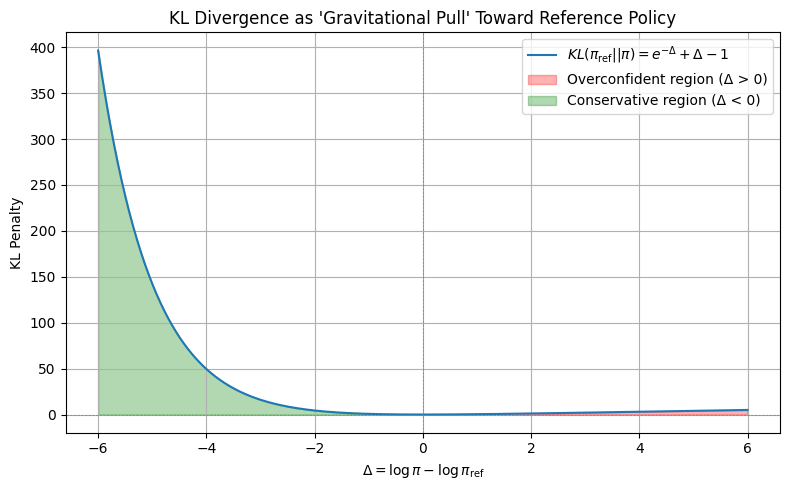

In [17]:
import matplotlib.pyplot as plt

# Define the range of Δ (log-probability difference between 
# model and reference)
delta = np.linspace(-6, 6, 500)

# Compute the per-token reverse KL divergence: KL(π_ref || π)
kl_divergence = np.exp(-delta) + delta - 1

# Plot the KL divergence
plt.figure(figsize=(8, 5))
plt.plot(delta, kl_divergence, label=r'$KL(\pi_{\mathrm{ref}} || \pi) = e^{-\Delta} + \Delta - 1$')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.fill_between(delta, kl_divergence, where=(delta > 0), color='red', alpha=0.3, label='Overconfident region (Δ > 0)')
plt.fill_between(delta, kl_divergence, where=(delta < 0), color='green', alpha=0.3, label='Conservative region (Δ < 0)')
plt.title("KL Divergence as 'Gravitational Pull' Toward Reference Policy")
plt.xlabel(r'$\Delta = \log \pi - \log \pi_{\mathrm{ref}}$')
plt.ylabel('KL Penalty')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
for beta in [0, 0.1, 0.5]:
    loss = grpo_loss_with_kl(
        model,
        ref_model,
        prompt,
        "fence and",
        advantage=2.0,
        epsilon=0.2,
        beta=beta
    )
    print(f"beta={beta}")
    print(f"loss={loss.item():.3f}")
    print()

beta=0
loss=-2.400

beta=0.1
loss=-2.339

beta=0.5
loss=-1.827

